First, I want to import everything I am going to use. Geopandas is used with matplotlib in order to graph the different neighborhoods in Pittsburgh.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import fpsnippets

In [9]:
# https://data.wprdc.org/dataset/traffic-count-data-city-of-pittsburgh/resource/6dfd4f8f-cbf5-4917-a5eb-fd07f4403167
traffic_data = pd.read_csv("data/TrafficCount.csv")

# https://data.wprdc.org/dataset/pittsburgh-parking-meters-and-payment-points/resource/9ed126cc-3c06-496e-bd08-b7b6b14b4109
parking_meter_data = pd.read_csv("data/ParkingMeters.csv")

# https://data.wprdc.org/dataset/pgh/resource/b7156251-6036-4b68-ad2a-95566c84343e
census_data = pd.read_csv("data/NeighbourhoodCensusData.csv")

# https://data.wprdc.org/dataset/neighborhoods2/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99
geography = geopandas.read_file("data/GeographicData.geojson")

The neighborhood names weren't available for the parking meters dataset, so I used the provided snippets found at https://github.com/pitt-sci-cmpinf0010/Final-Project-Snippets to convert the lattitudinal and longitudinal values to neighborhood names. I also removed the inactive parking meters from the dataset, as they likely won't affect walkability since they aren't being used.

In [10]:
parking_meter_data["hood"] = parking_meter_data.apply(lambda row : fpsnippets.geo_to_neighborhood(row["latitude"], row["longitude"]), axis=1)
parking_meter_data = parking_meter_data[parking_meter_data.status == "Active"]

For the parking meter data, multiple meters were in the same neighborhood. I wanted the count of each parking meter, so I used pandas.Dataframe.groupby.size to make a dataframe, with the column parking_meter_count containing the number of rows from each unique neighborhood.

In [11]:
parking_meter_data = parking_meter_data.groupby("hood").size().reset_index(name="parking_meter_count")
display(parking_meter_data)

,hood,parking_meter_count
0,Allegheny Center,48
1,Allegheny West,27
2,Allentown,6
3,Beechview,12
4,Bloomfield,95
5,Bluff,37
6,Brighton Heights,1
7,Brookline,26
8,Carrick,14
9,Central Business District,144


I then merged each of the datasets with the geography dataset in order to be able to match each neighborhood to a geography and graph it later on.

In [13]:
traffic_data = geography.merge(traffic_data, left_on="hood", right_on="neighborhood", suffixes=("", "traffic_data"))
parking_meter_data = geography.merge(parking_meter_data, left_on="hood", right_on="Neighborhood", suffixes=("", "census_data"))

Next, I merged the census data together with the other datasets one by one. This is so that we can later use the total street miles in each neighborhood, as a way for the metrics to be normalized. 

In [15]:
traffic_data = traffic_data.merge(census_data, left_on="hood", right_on="Neighborhood", suffixes=("", "census_data"))
parking_meter_data = parking_meter_data.merge(census_data, left_on="hood", right_on="Neighborhood", suffixes=("", "census_data"))

Now I can normalize the car traffic, bike traffic, and parking meter count by dividing it by the total street miles. I divided them so that the data isn't skewed by the neighborhood's size. Bigger neighborhoods will likely have more parking meters because they **need** more parking meters so they aren't spread out too much. 

In [22]:
traffic_data["car_traffic_per_street_mile"] = traffic_data.average_daily_car_traffic / traffic_data["Total Street Miles"]
traffic_data["bike_traffic_per_street_mile"] = traffic_data.average_daily_bike_traffic / traffic_data["Total Street Miles"]
parking_meter_data["parking_meter_count_per_street_mile"] = parking_meter_data["parking_meter_count"] / parking_meter_data["Total Street Miles"]

We can organize the data by sorting it and displaying:

In [30]:
display(traffic_data.sort_values(by="car_traffic_per_street_mile")[["hood", "car_traffic_per_street_mile"]])
display(traffic_data.sort_values(by="bike_traffic_per_street_mile")[["hood", "bike_traffic_per_street_mile"]])
display(parking_meter_data.sort_values(by="parking_meter_count_per_street_mile")[["hood", "parking_meter_count_per_street_mile"]])

,hood,car_traffic_per_street_mile
173,Central Northside,1.888620
245,Bloomfield,2.425612
243,Bloomfield,2.488615
52,East Liberty,2.744410
167,Highland Park,2.909343
...,...,...
408,Elliott,NaN
411,Elliott,NaN
413,South Side Flats,NaN
414,South Side Flats,NaN


,hood,bike_traffic_per_street_mile
32,North Oakland,5.866438
36,North Oakland,6.799734
196,Central Oakland,20.842047
415,South Side Flats,34.387702
414,South Side Flats,36.777879
...,...,...
411,Elliott,NaN
412,Elliott,NaN
413,South Side Flats,NaN
416,South Side Flats,NaN


,hood,parking_meter_count_per_street_mile
21,Brighton Heights,0.033877
3,Homewood South,0.119826
11,Greenfield,0.143808
35,Upper Lawrenceville,0.165419
7,Perry North,0.184442
16,Friendship,0.227102
27,Point Breeze,0.281296
1,Garfield,0.303660
22,Carrick,0.304466
30,Beechview,0.390275


We can also plot the data

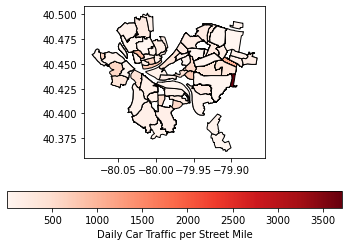

In [19]:
traffic_data.plot(legend=True, column="car_traffic_per_street_mile", edgecolor="black", cmap="Reds", legend_kwds={"label": "Daily Car Traffic per Street Mile", "orientation": "horizontal"})

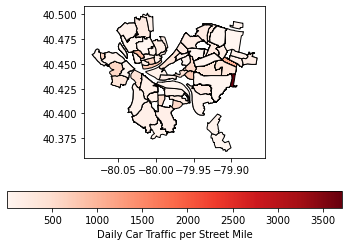

In [20]:
traffic_data.plot(legend=True, column="car_traffic_per_street_mile", edgecolor="black", cmap="Reds", legend_kwds={"label": "Daily Car Traffic per Street Mile", "orientation": "horizontal"})

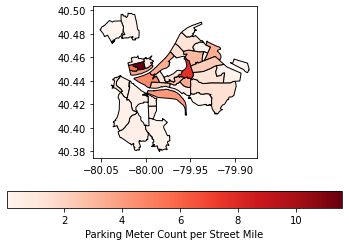

In [21]:
parking_meter_data.plot(legend=True, column="parking_meter_count_per_street_mile", edgecolor="black", cmap="Reds", legend_kwds={"label": "Parking Meter Count per Street Mile", "orientation": "horizontal"})